In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from glob import glob
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [8]:
# parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
BUFFER_SIZE = 10000
LATENT_DIM = 100
EPOCHS = 100

In [ ]:
# Load and preprocess the dataset
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_dataset(dataset_path):
    image_paths = glob(os.path.join(dataset_path, '*.jpg'))
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

# Define the generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Loss functions and optimizers
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

In [ ]:
# Optimizer values
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

In [ ]:
# Training step
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE // 2, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [2]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for real_images in dataset:
            gen_loss, disc_loss = train_step(real_images)
        print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

# Load the dataset
dataset_path = './archive/Celebrity_Faces_Dataset'  # Path to your dataset
train_dataset = load_dataset(dataset_path)

# Train the GAN
train(train_dataset, EPOCHS)


Epoch 1/100
Generator Loss: 3.7899, Discriminator Loss: 0.2402
Epoch 2/100
Generator Loss: 1.9688, Discriminator Loss: 0.7671
Epoch 3/100
Generator Loss: 1.2268, Discriminator Loss: 1.2300
Epoch 4/100
Generator Loss: 1.1093, Discriminator Loss: 1.1881
Epoch 5/100
Generator Loss: 1.0877, Discriminator Loss: 1.1512
Epoch 6/100
Generator Loss: 1.5389, Discriminator Loss: 0.8335
Epoch 7/100
Generator Loss: 1.2578, Discriminator Loss: 0.8210
Epoch 8/100
Generator Loss: 1.1506, Discriminator Loss: 1.0493
Epoch 9/100
Generator Loss: 1.3185, Discriminator Loss: 0.8834
Epoch 10/100
Generator Loss: 1.2296, Discriminator Loss: 0.9134
Epoch 11/100
Generator Loss: 1.1566, Discriminator Loss: 1.4285
Epoch 12/100
Generator Loss: 1.4865, Discriminator Loss: 1.0476
Epoch 13/100
Generator Loss: 1.1687, Discriminator Loss: 0.8515
Epoch 14/100
Generator Loss: 1.0607, Discriminator Loss: 1.1189
Epoch 15/100
Generator Loss: 1.5272, Discriminator Loss: 0.9742
Epoch 16/100
Generator Loss: 1.8242, Discriminato

In [11]:

def generate_and_save_images(generator, num_examples=16):
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated_images = generator(noise, training=False)
    plt.figure(figsize=(4, 4))
    plt.imshow(noise)
    plt.title("Noise")

    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')

    # plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.show()


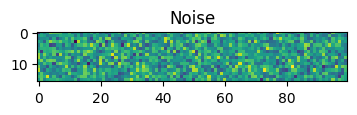

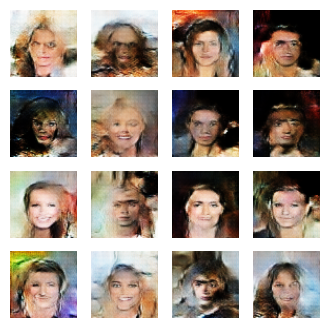

In [12]:
generate_and_save_images(generator)

In [ ]:
# Function to save models
def save_models(generator, discriminator, path):
    generator.save(os.path.join(path, 'generator.h5'))
    discriminator.save(os.path.join(path, 'discriminator.h5'))

# Function to load models
def load_models(path):
    generator = tf.keras.models.load_model(os.path.join(path, 'generator.h5'))
    discriminator = tf.keras.models.load_model(os.path.join(path, 'discriminator.h5'))
    return generator, discriminator


In [6]:
# save_models(generator, discriminator, 'models')
generator, discriminator = load_models('models')